<a href="https://colab.research.google.com/github/jaeohshin/keras/blob/main/tutorial_5_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here we use Convnet to distinguish between dogs and cats from kaggle data.


In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jaeohshin","key":"b06496892a173235f5af3b31663da13d"}'}

In [8]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle competitions download -c dogs-vs-cats --force

 98% 796M/812M [00:08<00:00, 155MB/s]
100% 812M/812M [00:08<00:00, 102MB/s]


In [10]:
!unzip -qq dogs-vs-cats.zip

In [12]:
!unzip -qq train.zip

replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [13]:
#Separate the train data into three categories: train, validation, and test
# Each has 1000, 500, and 1000 images.

import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

Building a model

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [15]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

In [16]:
model.compile(loss = "binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [17]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [18]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("label batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
label batch shape: (32,)


In [19]:
callbacks = [
    keras.callbacks.ModelCheckpoint (
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]



In [26]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 18s 95ms/step - loss: 0.6965 - accuracy: 0.4955 - val_loss: 0.6927 - val_accuracy: 0.5170
Epoch 2/30
63/63 [==============================] - 4s 62ms/step - loss: 0.6938 - accuracy: 0.5135 - val_loss: 0.6909 - val_accuracy: 0.5070
Epoch 3/30
63/63 [==============================] - 6s 84ms/step - loss: 0.6964 - accuracy: 0.5580 - val_loss: 0.9158 - val_accuracy: 0.5000
Epoch 4/30
63/63 [==============================] - 4s 61ms/step - loss: 0.6511 - accuracy: 0.6200 - val_loss: 0.6315 - val_accuracy: 0.6390
Epoch 5/30
63/63 [==============================] - 4s 62ms/step - loss: 0.6163 - accuracy: 0.6440 - val_loss: 0.6300 - val_accuracy: 0.6490
Epoch 6/30
63/63 [==============================] - 5s 78ms/step - loss: 0.5926 - accuracy: 0.6885 - val_loss: 0.7208 - val_accuracy: 0.6060
Epoch 7/30
63/63 [==============================] - 4s 66ms/step - loss: 0.5549 - accuracy: 0.7170 - val_loss: 0.5872 - val_accuracy: 0.6770
Epoch 8/30
6

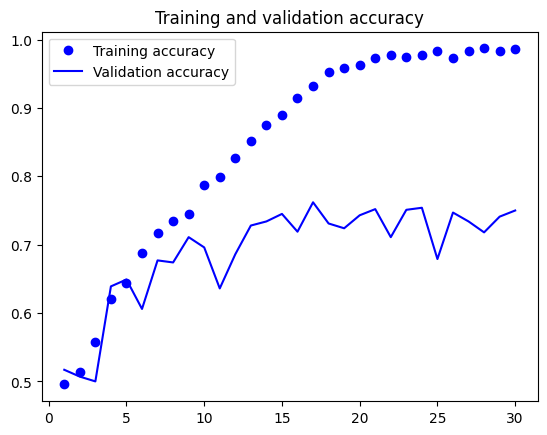

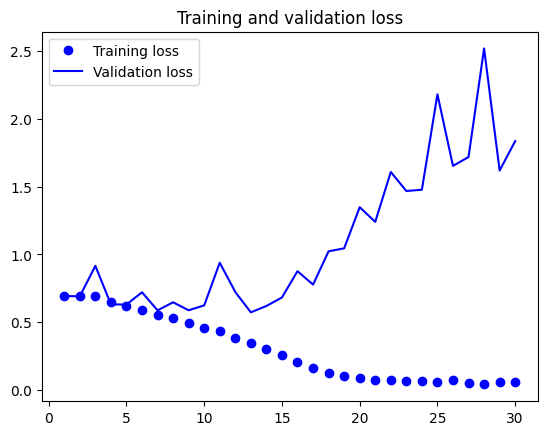

In [27]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [28]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc: .3f}")

63/63 [==============================] - 2s 33ms/step - loss: 0.6338 - accuracy: 0.7085
Test accuracy:  0.709


In [32]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## The accuracy is about 68%. We need to use several techniques to improve it below.

1.   Overfitting: Caused by limited training data. We will use data augmentation, i.e., generating more traning data by randomly trasforming the original data.

2.   List item





In [20]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

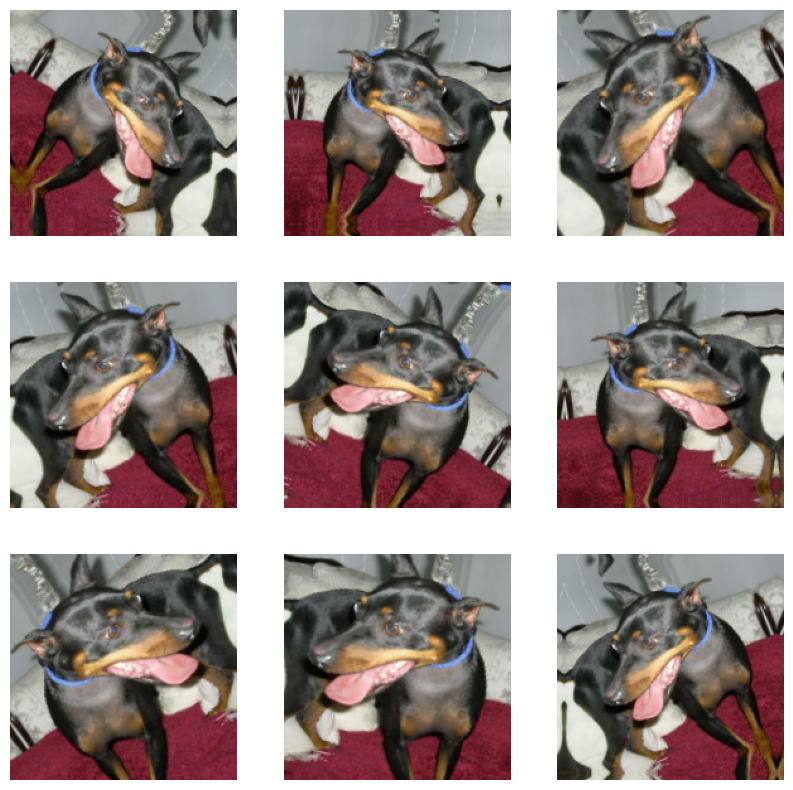

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#New convnet with data augmentation and drop out

In [23]:
from tensorflow import keras

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 20s 104ms/step - loss: 0.6966 - accuracy: 0.5110 - val_loss: 0.7116 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 5s 67ms/step - loss: 0.6986 - accuracy: 0.5170 - val_loss: 0.7075 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 6s 89ms/step - loss: 0.6946 - accuracy: 0.5315 - val_loss: 0.6921 - val_accuracy: 0.5010
Epoch 4/100
63/63 [==============================] - 4s 67ms/step - loss: 0.6905 - accuracy: 0.5465 - val_loss: 0.6812 - val_accuracy: 0.5370
Epoch 5/100
63/63 [==============================] - 5s 68ms/step - loss: 0.6714 - accuracy: 0.5895 - val_loss: 0.6569 - val_accuracy: 0.6250
Epoch 6/100
63/63 [==============================] - 6s 97ms/step - loss: 0.6530 - accuracy: 0.6220 - val_loss: 0.6787 - val_accuracy: 0.5340
Epoch 7/100
63/63 [==============================] - 5s 68ms/step - loss: 0.6214 - accuracy: 0.6485 - val_loss: 0.7113 - val_accuracy: 0.5940
Epoc

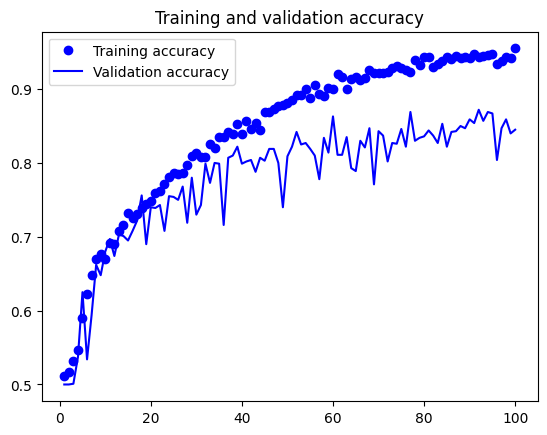

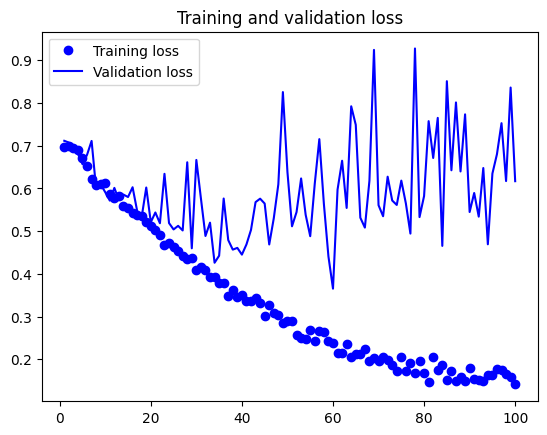

In [25]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [26]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 33ms/step - loss: 0.4195 - accuracy: 0.8470
Test accuracy: 0.847


#Saved convnet_from_scratch_with_augmentation.keras 바탕화면